In [1]:
import tensorflow as tf
import qkera_experiments.dataset as dataset
from tensorflow import keras
from keras import layers
from qkeras import *

# load the dataset

In [2]:
x_train, y_train, x_test, y_test = dataset.load_cifar10()

(50000, 1)


# define learning rate scheduler

In [3]:
class ResNetPaperLR(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, initial_lr = 0.1, learning_rate_decay=10, steps=[32000, 48000]):
        super(ResNetPaperLR, self).__init__()
        self.initial_lr = initial_lr
        self.learning_rate_decay = learning_rate_decay
        self.steps = steps
        self.current_lr = 0
    def __call__(self, step):        
        step12 = tf.where(step < self.steps[1], self.initial_lr/self.learning_rate_decay, self.initial_lr/(self.learning_rate_decay**2))    
        step01 = tf.where(step < self.steps[0], self.initial_lr, step12)
        return step01
                         

    def get_config(self):
        return {
            "initial_lr": self.initial_lr,
            "learning_rate_decay": self.learning_rate_decay,
            "steps": self.steps
        }

# load the quantized model model

In [4]:
from qkeras.utils import load_qmodel


qmodel = load_qmodel("qkera_experiments/qmodels/vgg16/model.h5", custom_objects={"ResNetPaperLR":ResNetPaperLR})
qmodel.evaluate(x_test, y_test)

x_in = qmodel.layers[0].input
x_out = qmodel.layers[-6].output

base_model = keras.Model(inputs=[x_in], outputs=[x_out])
base_model.summary()

del qmodel

c:\Users\georg\Desktop\mestrado_luiz\deep_nibble_dnn\.venv\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


313/313 [==============================] - 10s 19ms/step - loss: 1.0317 - accuracy: 0.7315
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 32, 32, 3)]       0         
                                                                 
 q_activation (QActivation)  (None, 32, 32, 3)         0         
                                                                 
 conv2d (QConv2D)            (None, 32, 32, 64)        1792      
                                                                 
 re_lu (QActivation)         (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (QConv2D)          (None, 32, 32, 64)        36928     
                                                                 
 re_lu_1 (QActivation)       (None, 32, 32, 64)        0         
                                    

# including base model as a preprocessing component of the Deep Nibble MLP training

In [5]:
# preprocess the dataset
x_train_2 = base_model.predict(x_train)
print(x_train_2.shape)
# preprocess the dataset
x_test_2 = base_model.predict(x_test)
print(x_test_2.shape)

1563/1563 [==============================] - 25s 16ms/step
(50000, 4096)
313/313 [==============================] - 5s 16ms/step
(10000, 4096)


# training Deep Nibble

In [6]:
import numpy as np
import tensorflow as tf
from mlp_from_scratch.NeuralNetwork import QNeuralNetworkWithScale


# Define neural network inputnoutput
input_size = x_train_2.shape[1]
output_size = y_train.shape[1]

print(x_train_2.shape, x_test_2.shape, y_train.shape, y_test.shape)



(50000, 4096) (10000, 4096) (50000, 10) (10000, 10)


In [7]:
deep_nibble_history = []

for i in range(10):

    # Create and train the neural network
    neural_network_with_scale = QNeuralNetworkWithScale(input_size, output_size)

    # train the nn
    neural_network_with_scale.train(x_train_2, y_train, learning_rate=0.0000100, num_epochs=1, batch_size=256, x_val=x_test_2, y_val=y_test)
    neural_network_with_scale.train(x_train_2, y_train, learning_rate=0.000100, num_epochs=4, batch_size=256, x_val=x_test_2, y_val=y_test)
    neural_network_with_scale.train(x_train_2, y_train, learning_rate=0.000010, num_epochs=5, batch_size=256, x_val=x_test_2, y_val=y_test)

    neural_network_with_scale.save_weights(f"dn_models/deep_nibble_model_{i}")

    np.save(f"dn_models/deep_nibble_model_{i}/loss_hist", np.array(neural_network_with_scale.loss_hist))
    np.save(f"dn_models/deep_nibble_model_{i}/acc_hist", np.array(neural_network_with_scale.acc_hist))

    deep_nibble_history.append((neural_network_with_scale.loss_hist , neural_network_with_scale.acc_hist))
    


Epoch 1/1, Loss: 0.00861329399049282 Accuracy: 33.61000061035156%
Epoch 1/4, Loss: 0.004037961363792419 Accuracy: 67.66999816894531%
Epoch 2/4, Loss: 0.0021830874029546976 Accuracy: 69.16999816894531%
Epoch 3/4, Loss: 0.0019696818199008703 Accuracy: 69.4800033569336%
Epoch 4/4, Loss: 0.001957870554178953 Accuracy: 69.84000396728516%
Epoch 1/5, Loss: 0.0019057218451052904 Accuracy: 70.38999938964844%
Epoch 2/5, Loss: 0.001929430291056633 Accuracy: 69.5%
Epoch 3/5, Loss: 0.0019082585349678993 Accuracy: 70.4800033569336%
Epoch 4/5, Loss: 0.001902936608530581 Accuracy: 69.6500015258789%
Epoch 5/5, Loss: 0.001941316993907094 Accuracy: 69.59000396728516%
Epoch 1/1, Loss: 0.008566461503505707 Accuracy: 36.46999740600586%
Epoch 1/4, Loss: 0.0038640133570879698 Accuracy: 68.77999877929688%
Epoch 2/4, Loss: 0.002166891237720847 Accuracy: 69.56999969482422%
Epoch 3/4, Loss: 0.0019479832844808698 Accuracy: 70.54000091552734%
Epoch 4/4, Loss: 0.0019263253780081868 Accuracy: 69.7300033569336%
Epoch 

# training fp32

In [8]:
def scheduler(epoch):
  if epoch < 1:
    return 0.001
  elif epoch < 5:
    return 0.01
  else:
    return 0.001
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)


fp_history = []

for i in range(10):
  x = x_in = keras.layers.Input((4096))
  x = keras.layers.Dense(units=256, activation="relu")(x)
  x = keras.layers.Dense(units=256, activation="relu")(x)
  x = keras.layers.Dense(units=10)(x)
  fp_model = keras.Model(inputs=x_in, outputs=x)
  fp_model.compile(keras.optimizers.SGD(learning_rate=0.001), loss=keras.losses.CategoricalCrossentropy(from_logits=True), metrics=["accuracy"])
  fp_hist = fp_model.fit(x_train_2, y_train, batch_size=256, epochs=10, validation_data=(x_test_2, y_test), callbacks=[callback])

  fp_model.save(f"fp_models/model_{i}.h5")
  np.save(f"fp_models/model_{i}_acc_hist",  np.array(fp_hist.history["val_loss"]))
  np.save(f"fp_models/model_{i}_loss_hist",  np.array(fp_hist.history["val_accuracy"]))

  fp_history.append((fp_hist.history["val_loss"], fp_hist.history["val_accuracy"]))


Epoch 1/10
196/196 [==============================] - 1s 3ms/step - loss: 2.2886 - accuracy: 0.1173 - val_loss: 2.2761 - val_accuracy: 0.1327 - lr: 0.0010
Epoch 2/10
196/196 [==============================] - 1s 3ms/step - loss: 2.0822 - accuracy: 0.3987 - val_loss: 1.8296 - val_accuracy: 0.5336 - lr: 0.0100
Epoch 3/10
196/196 [==============================] - 1s 3ms/step - loss: 1.4433 - accuracy: 0.6523 - val_loss: 1.2276 - val_accuracy: 0.6537 - lr: 0.0100
Epoch 4/10
196/196 [==============================] - 1s 3ms/step - loss: 0.9500 - accuracy: 0.7619 - val_loss: 0.9667 - val_accuracy: 0.6958 - lr: 0.0100
Epoch 5/10
196/196 [==============================] - 1s 3ms/step - loss: 0.7217 - accuracy: 0.8023 - val_loss: 0.8625 - val_accuracy: 0.7104 - lr: 0.0100
Epoch 6/10
196/196 [==============================] - 1s 3ms/step - loss: 0.6433 - accuracy: 0.8165 - val_loss: 0.8550 - val_accuracy: 0.7130 - lr: 0.0010
Epoch 7/10
196/196 [==============================] - 1s 3ms/step - lo

# training po2

In [10]:
def scheduler(epoch):
  if epoch < 1:
    return 0.0001
  elif epoch < 5:
    return 0.001
  else:
    return 0.0001
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

po2_history = []

for i in range(10):

  x = x_in = keras.layers.Input((4096))
  x = QActivation(activation="quantized_relu_po2(4,1, use_stochastic_rounding=True)")(x)
  x = QDense(units=256, kernel_quantizer=quantized_po2(4,1, use_stochastic_rounding=True), bias_quantizer=(quantized_po2(4,1, use_stochastic_rounding=True)))(x)
  x = QActivation(activation="quantized_relu_po2(4,1, use_stochastic_rounding=True)")(x)
  x = QDense(units=256, kernel_quantizer=quantized_po2(4,1, use_stochastic_rounding=True), bias_quantizer=(quantized_po2(4,1, use_stochastic_rounding=True)))(x)
  x = QActivation(activation="quantized_relu_po2(4,1, use_stochastic_rounding=True)")(x)
  x = QDense(units=10, kernel_quantizer=quantized_po2(4,1, use_stochastic_rounding=True), bias_quantizer=(quantized_po2(4,1, use_stochastic_rounding=True)))(x)
  # x = QActivation(activation=quantized_bits(4, 0, 1, use_stochastic_rounding=False))(x)
  po2_model = keras.Model(inputs=x_in, outputs=x)
  po2_model.compile(keras.optimizers.SGD(learning_rate=0.0001), loss=keras.losses.CategoricalCrossentropy(from_logits=True), metrics=["accuracy"])

  po2_hist = po2_model.fit(x_train_2, y_train, batch_size=256, epochs=10, validation_data=(x_test_2, y_test), callbacks=[callback])

  po2_model.save(f"po2_models/model_{i}.h5")
  np.save(f"po2_models/model_{i}_acc_hist",  np.array(po2_hist.history["val_accuracy"]))
  np.save(f"po2_models/model_{i}_loss_hist",  np.array(po2_hist.history["val_loss"]))


  po2_history.append((po2_hist.history["val_loss"], po2_hist.history["val_accuracy"]))



Epoch 1/10
196/196 [==============================] - 2s 8ms/step - loss: 2.3346 - accuracy: 0.1044 - val_loss: 2.3317 - val_accuracy: 0.1049 - lr: 1.0000e-04
Epoch 2/10
196/196 [==============================] - 1s 6ms/step - loss: 2.2842 - accuracy: 0.1435 - val_loss: 2.2490 - val_accuracy: 0.1800 - lr: 0.0010
Epoch 3/10
196/196 [==============================] - 1s 6ms/step - loss: 2.2003 - accuracy: 0.2297 - val_loss: 2.1683 - val_accuracy: 0.2658 - lr: 0.0010
Epoch 4/10
196/196 [==============================] - 1s 6ms/step - loss: 2.1153 - accuracy: 0.3270 - val_loss: 2.0876 - val_accuracy: 0.3507 - lr: 0.0010
Epoch 5/10
196/196 [==============================] - 1s 6ms/step - loss: 2.0291 - accuracy: 0.4110 - val_loss: 2.0070 - val_accuracy: 0.4141 - lr: 0.0010
Epoch 6/10
196/196 [==============================] - 1s 6ms/step - loss: 1.9797 - accuracy: 0.4488 - val_loss: 1.9982 - val_accuracy: 0.4217 - lr: 1.0000e-04
Epoch 7/10
196/196 [==============================] - 1s 6ms/s

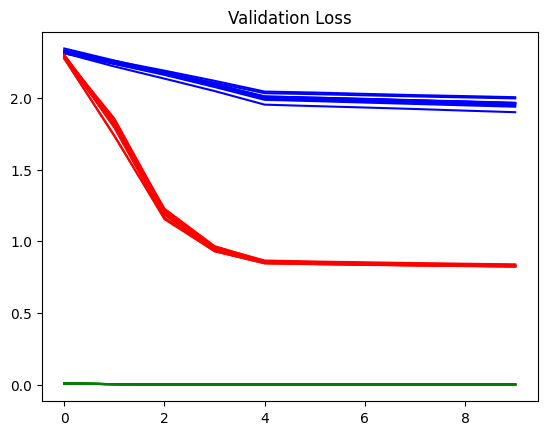

In [11]:
import matplotlib.pyplot as plt

for i in range(10):
    dn_loss = deep_nibble_history[i][0]
    
    plt.plot(fp_history[i][0], label='FP32', color="red")
    plt.plot(po2_history[i][0], label='Po2 4-bits', color="blue")
    plt.plot(dn_loss, label='Deep Nibble', color="green")    
    plt.title('Validation Loss')

# plt.legend()
plt.show()   

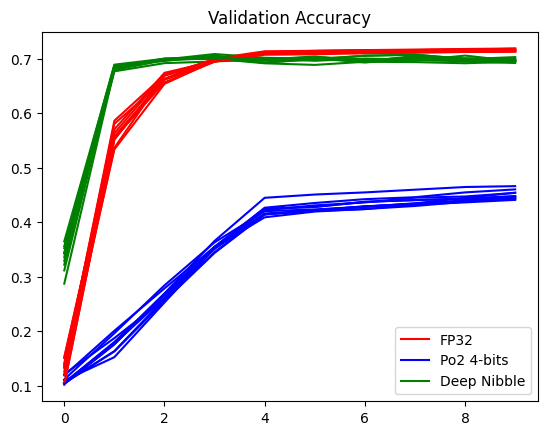

In [15]:
for i in range(10):
    dn_acc = deep_nibble_history[i][1]
        
    plt.plot(fp_history[i][1], color="red")
    plt.plot(po2_history[i][1], color="blue")
    plt.plot(dn_acc, color="green")    
    plt.title('Validation Accuracy')

plt.plot(fp_history[i][1], label='FP32', color="red")
plt.plot(po2_history[i][1], label='Po2 4-bits', color="blue")
plt.plot(dn_acc, label='Deep Nibble', color="green")    
plt.title('Validation Accuracy. 10 trials')
plt.legend()
plt.show()   

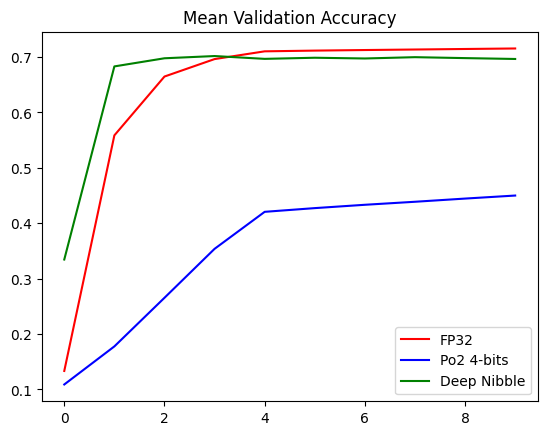

In [16]:
dn_acc = np.mean(np.array(deep_nibble_history)[:,1,:], axis=0)
fp_acc = np.mean(np.array(fp_history)[:,1,:], axis=0)
po2_acc = np.mean(np.array(po2_history)[:,1,:], axis=0)

plt.plot(fp_acc, label='FP32', color="red")
plt.plot(po2_acc, label='Po2 4-bits', color="blue")
plt.plot(dn_acc, label='Deep Nibble', color="green")    
plt.title('Mean Validation Accuracy')

plt.legend()
plt.show()   

In [17]:
print(np.max(fp_acc))
print(np.max(dn_acc))
print(np.max(po2_acc))

0.7155099987983704
0.70185006
0.4499800056219101


In [ ]:
import matplotlib.pyplot as plt



#plt.plot(history.history["loss"])
plt.plot(fp_hist.history["val_loss"], label='FP32')
plt.plot(po2_hist.history["val_loss"], label='Po2 4-bits')
plt.plot(neural_network_with_scale.loss_hist, label='Deep Nibble')
plt.legend()
plt.title('Validation Loss')
plt.show()    
#plt.plot(history.history["accuracy"])
plt.plot(fp_hist.history["val_accuracy"], label='FP32')
plt.plot(po2_hist.history["val_accuracy"],  label='Po2 4-bits')
plt.plot(neural_network_with_scale.acc_hist, label='Deep Nibble')
plt.legend()
plt.title('Validation Accuracy Cifar10')
plt.xlabel('Epochs')
plt.ylabel('Accuracy Top-1')
plt.xticks(range(0, 20, 2))

plt.show()    

In [ ]:
print(np.array(neural_network_with_scale.acc_hist))